### Arctic Amplification ###

Assessing the differential temperature trends of the Arctic compared to the global mean, in both observations (ERA5) and model (HadGEM3-GC31-MM). In terms of both:

1. Trend in the winter mean (e.g., DJF mean)
2. Trend in the seasonal block minima (e.g., DJF block min T day)

In [1]:
# Local imports
import os
import sys
import glob
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import iris
import cftime

# Specific imports
from tqdm import tqdm
from matplotlib import gridspec
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from scipy.stats import linregress, percentileofscore, gaussian_kde, pearsonr
from scipy.stats import genextreme as gev
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from iris.util import equalise_attributes

# local imports
from gev_functions import pivot_detrend_obs

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
%%time
# ------------------------------------
# First import the monthly mean ERA5 temperature data
# ------------------------------------

# Test this path - ERA5 regridded to HadGEM grid
t2m_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/t2m_ERA5_regrid_HadGEM.nc"

# Load the path using xarray
obs = xr.open_mfdataset(
    t2m_path,
    combine="by_coords",
    parallel=False,
    engine="netcdf4",
)

# If expver is present in the observations
if "expver" in obs.coords:
    # Combine the first two expver variables
    obs = obs.sel(expver=1).combine_first(obs.sel(expver=5))

# process into an iris cube
temp_cube = obs["t2m"].squeeze().to_iris()

CPU times: user 59.9 ms, sys: 21.2 ms, total: 81.1 ms
Wall time: 131 ms


In [3]:
# --------------------------------------
# Set the lons of this tro -180 to 180
# --------------------------------------

temp_cube = temp_cube.intersection(longitude=(-180, 180))

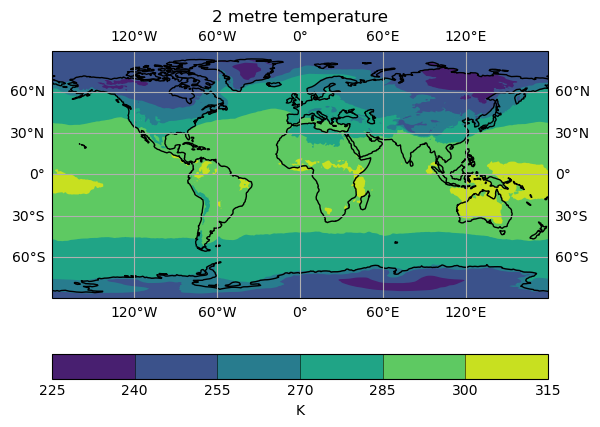

In [4]:
# --------------------------------------
# Quickplot the first time coordinate of temp cube
# --------------------------------------

import iris.quickplot as qplt

qplt.contourf(temp_cube[0], cmap="viridis")

# add coastlines
ax = plt.gca()

ax.coastlines()

# add gridlines
ax.gridlines(draw_labels=True)

# show the plot
plt.show()

In [5]:
# ----------------------------------------
# Pre-process the iris cube to the correct dimensions
# ----------------------------------------

import iris.coord_categorisation

# Make sure the cube only contains DJFs
temp_cube = temp_cube.extract(iris.Constraint(time=lambda t: t.point.month in [12, 1, 2]))

# AQdd the clim season diemsinsion
iris.coord_categorisation.add_season(temp_cube, "time", name="clim_season")

# Add the season year dimension
iris.coord_categorisation.add_season_year(temp_cube, "time", name="season_year")

# Now aggregate by clim season and season year to get the DJF mean
temp_cube = temp_cube.aggregated_by(["clim_season", "season_year"], iris.analysis.MEAN)

In [6]:
temp_cube

<iris 'Cube' of 2 metre temperature / (K) (time: 65; latitude: 324; longitude: 432)>

In [7]:
%%time
# ----------------------------------------
# Now we want to plot a time series of the arctic temperature
# Relative to the global mean temperature 
# ----------------------------------------

# Subset the cube to the arctic region (66.5 - 90N)
temp_cube_arctic = temp_cube.extract(iris.Constraint(latitude=lambda x: x > 66.5))

# Calculate the spatial mean
temp_arctic = temp_cube_arctic.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

# Calculate the climatologfy
clim_arctic = temp_arctic.collapsed("time", iris.analysis.MEAN)

# Calculate the anomalies
temp_arctic_anom = temp_arctic - clim_arctic

# Extract the values
temp_arctic_anom_values = temp_arctic_anom.data

# Cclaulte the global climatology
clim_global = temp_cube.collapsed("time", iris.analysis.MEAN)

# Calculate the global anomalies
temp_global_anom = temp_cube.collapsed(["latitude", "longitude"], iris.analysis.MEAN) - clim_global.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

# Extract the values
temp_global_anom_values = temp_global_anom.data

# Extract the years
years = temp_cube.coord("season_year").points

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/pytho

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitud

CPU times: user 4.03 s, sys: 3.61 s, total: 7.63 s
Wall time: 6.36 s


In [8]:
temp_global_anom_values.shape

(65,)

Text(0.5, 1.0, 'Arctic and Global DJF Mean Temperature Anomalies (1980-2020)')

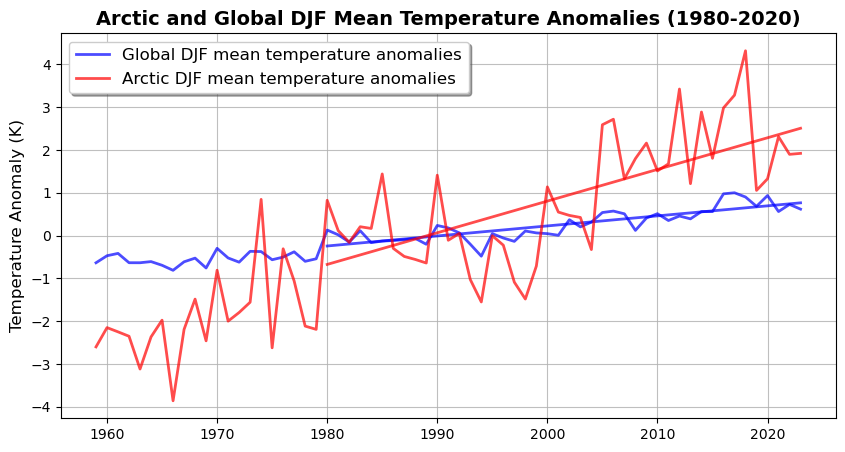

In [9]:
# plot the time series
plt.figure(figsize=(10, 5))

# add faint gridlines
plt.grid(alpha=0.8)

# plot the global mean temperature
plt.plot(
    years,
    temp_global_anom_values,
    label="Global DJF mean temperature anomalies",
    color="blue",
    alpha=0.7,
    linewidth=2,
)

# Calculate a linear trend for the global mean temperature
slope, intercept, r_value, p_value, std_err = linregress(years[years >= 1980], temp_global_anom_values[years >= 1980])

# calculate the trend line
trend_line = slope * years + intercept

# plot the trend line
plt.plot(
    years[years >= 1980],
    trend_line[years >= 1980],
    color="blue",
    alpha=0.7,
    linewidth=2,
)

# Plot the arctic mean temperature
plt.plot(
    years,
    temp_arctic_anom_values,
    label="Arctic DJF mean temperature anomalies",
    color="red",
    alpha=0.7,
    linewidth=2,
)

# include a linear trend from the 1980s onwards
# calculate the linear trend
slope, intercept, r_value, p_value, std_err = linregress(years[years >= 1980], temp_arctic_anom_values[years >= 1980])

# calculate the trend line
trend_line = slope * years + intercept

# plot the trend line
plt.plot(
    years[years >= 1980],
    trend_line[years >= 1980],
    color="red",
    alpha=0.7,
    linewidth=2,
)

# include a legend in the top left
plt.legend(
    loc="upper left",
    fontsize=12,
    frameon=True,
    shadow=True,
    fancybox=True,
)

# set a ylabel
plt.ylabel("Temperature Anomaly (K)", fontsize=12)

# Set up the title
plt.title(
    "Arctic and Global DJF Mean Temperature Anomalies (1980-2020)",
    fontsize=14,
    fontweight="bold",
)

In [10]:
%%time
# ------------------------------------
# Now load in the model data to plot the same thing
# ------------------------------------
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import load_model_data_xarray

# Load the model data for tas
model_tas = load_model_data_xarray(
    model_variable="tas",
    model="HadGEM3-GC31-MM",
    experiment="dcppA-hindcast",
    start_year=1960,
    end_year=2018, # test first
    first_fcst_year=1960 + 1,
    last_fcst_year=1965,
    months=[12, 1, 2],
    parallel=False,
)


Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/tas/HadGEM3-GC31-MM/merged_files
The model path root is gws
Number of unique variant labels: 10
For model: HadGEM3-GC31-MM
First 10 unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
Number of unique variant labels: 10
Unique variant labels: ['r10i1p1f2' 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2' 'r5i1p1f2'
 'r6i1p1f2' 'r7i1p1f2' 'r8i1p1f2' 'r9i1p1f2']
First 10 model files: ['tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r10i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r3i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r4i1p1f2_gn_196011-197103.nc', 'tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r5i1p1f2_gn_196011-197103.nc'

Processing init years:  10%|█         | 6/59 [00:00<00:06,  8.00it/s]

Processing init years:  24%|██▎       | 14/59 [00:39<03:31,  4.69s/it]

In [34]:
model_tas

<xarray.Dataset> Size: 4GB
Dimensions:    (init: 6, member: 10, lead: 125, bnds: 2, lon: 432, lat: 324)
Coordinates:
  * lead       (lead) int64 1kB 1 2 3 4 5 6 7 8 ... 119 120 121 122 123 124 125
  * lon        (lon) float64 3kB 0.4167 1.25 2.083 2.917 ... 357.9 358.7 359.6
  * lat        (lat) float64 3kB -89.72 -89.17 -88.61 ... 88.61 89.17 89.72
    height     float64 8B 1.5
  * member     (member) int64 80B 10 1 2 3 4 5 6 7 8 9
  * init       (init) int64 48B 1960 1961 1962 1963 1964 1965
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (init, member, lead, bnds) object 120kB dask.array<chunksize=(1, 1, 1, 2), meta=np.ndarray>
    lon_bnds   (init, member, lon, bnds) float64 415kB dask.array<chunksize=(1, 1, 432, 2), meta=np.ndarray>
    lat_bnds   (init, member, lat, bnds) float64 311kB dask.array<chunksize=(1, 1, 324, 2), meta=np.ndarray>
    tas        (init, member, lead, lat, lon) float32 4GB dask.array<chunksize=(1, 1, 1, 324, 432), meta=np.ndarray>
Attributes: (12/47)
    CDI:                    Climate Data Interface version 2.0.4 (https://mpi...
    source:                 HadGEM3-GC31-MM (2016): \naerosol: UKCA-GLOMAP-mo...
    institution:            Met Office Hadley Centre, Fitzroy Road, Exeter, D...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    ...                     ...
    variant_label:          r10i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0
    CDO:                    Climate Data Operators version 2.0.4 (https://mpi...
    first_month:            1960-11-16 00:00:00
    time_axis_type:         Datetime360Day

In [35]:
# convert model tas to iris cube
model_tas_cube = model_tas["tas"].squeeze().to_iris()

In [36]:
model_tas_cube

<iris 'Cube' of air_temperature / (K) (init: 6; -- : 10; lead: 125; latitude: 324; longitude: 432)>

In [42]:
# ------------------------------------
# Create a new coordinate for the winter year
# -------------------------------------

# Extract the specific leads
leads_to_extract = []

# set up the winter years
winter_years = np.arange(1, 11 + 1, 1)

for i, winter_year in enumerate(winter_years):
    # Set up the leads this
    leads_to_extract.extend(
        np.arange(
            (i * 12) + 2,
            (i * 12) + 2 + 3,
        )
    )

# Forma these as ints
leads_to_extract = [int(i) for i in leads_to_extract]

# subset the cube to the leads we want
model_tas_cube = model_tas_cube.extract(iris.Constraint(lead=lambda x: x in leads_to_extract))

# Set a function for calculating the winter year
def lead_to_wyear(lead):
    return (lead - 2) // 12 + 1

# Get the lead coordinate
lead_coord = model_tas_cube.coord("lead")

# Apply the function to create winter year values
winter_years = np.array([lead_to_wyear(lead) for lead in leads_to_extract])

# create a new coordinate for the winter year
winter_year_coord = iris.coords.AuxCoord(
    winter_years,
    long_name="winter_year",
)

# Add the new coordinate to the cube
model_tas_cube.add_aux_coord(winter_year_coord, data_dims=model_tas_cube.coord_dims("lead"))

In [46]:
model_tas_cube.coords("winter_year")

[<AuxCoord: winter_year / (unknown)  [ 1, 1, ..., 11, 11]  shape(33,)>]

In [47]:
# group the cube by winter year and take means over the leads
model_tas_cube_wyear = model_tas_cube.aggregated_by(["winter_year"], iris.analysis.MEAN)

In [49]:
model_tas_cube_wyear.coords("init")

[<DimCoord: init / (unknown)  [1960, 1961, ..., 1964, 1965]  shape(6,)>]

In [50]:
model_tas_cube_wyear.shape

(6, 10, 11, 324, 432)

In [51]:
# intersect between -180 and 180
model_tas_cube_wyear = model_tas_cube_wyear.intersection(longitude=(-180, 180))

In [52]:
model_tas_cube_wyear

Air Temperature (K),init,--,lead,latitude,longitude
Shape,6,10,11,324,432
Dimension coordinates,,,,,
init,x,-,-,-,-
lead,-,-,x,-,-
latitude,-,-,-,x,-
longitude,-,-,-,-,x
Auxiliary coordinates,,,,,
member,-,x,-,-,-
winter_year,-,-,x,-,-
Scalar coordinates,,,,,


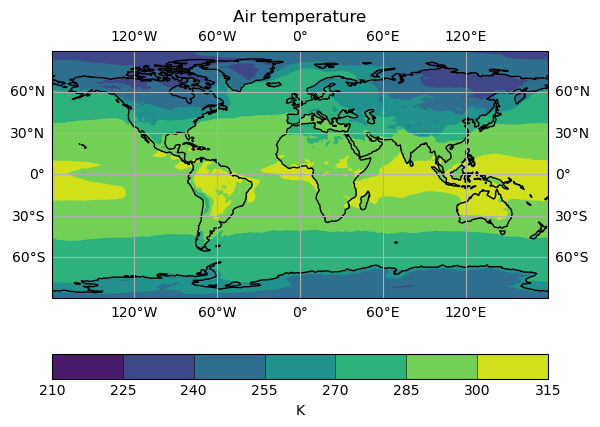

In [53]:
# ------------------------------------
# Quickplot the first time coordinate of model_tas_cube_wyear
# --------------------------------------

qplt.contourf(model_tas_cube_wyear[0, 0, 0, :, :], cmap="viridis")

# add coastlines
ax = plt.gca()

ax.coastlines()

# add gridlines
ax.gridlines(draw_labels=True)

# show the plot
plt.show()

In [54]:
# -------------------------------------
# Calculate the climatology for the model for global mean
# and arctic region T
# -------------------------------------

# Subset the model data to the arctic region
model_tas_cube_arctic = model_tas_cube_wyear.extract(iris.Constraint(latitude=lambda x: x > 66.5))

# Calculate the spatial mean
model_tas_cube_arctic_clim = model_tas_cube_arctic.collapsed(["init", "member", "lead", "latitude", "longitude"], iris.analysis.MEAN)

# Calculate the climatology global
model_tas_cube_clim = model_tas_cube_wyear.collapsed(["init", "member", "lead", "latitude", "longitude"], iris.analysis.MEAN)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'init', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'init'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'lead'.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bou

In [57]:
model_tas_cube_arctic.shape

(6, 10, 11, 42, 432)

In [61]:
model_tas_cube_wyear.shape

(6, 10, 11, 324, 432)

In [64]:
# -------------------
# Process the spatial means
# -------------------
model_tas_cube_arctic_ts = model_tas_cube_arctic.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

model_tas_cube_global_ts = model_tas_cube_wyear.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/pytho

In [65]:
model_tas_cube_arctic_ts.shape

(6, 10, 11)

In [67]:
model_tas_cube_global_ts.shape

(6, 10, 11)

In [68]:
%%time
# ------------------------------------
# extract the data for these
# ------------------------------------

model_tas_cube_arctic_ts_vals = model_tas_cube_arctic_ts.data
model_tas_cube_global_ts_vals = model_tas_cube_global_ts.data

# Extract the years
winter_years = model_tas_cube_arctic_ts.coord("winter_year").points
init_years = model_tas_cube_arctic_ts.coord("init").points
members = model_tas_cube_arctic_ts.coord("member").points

CPU times: user 20.9 s, sys: 2.92 s, total: 23.8 s
Wall time: 16.3 s


In [71]:
# -------------------------------------
# Append this data to a dataframe
# -------------------------------------

# Set up an empty dataframe
temps_df = pd.DataFrame()

# loop over the init years
for i, init_year in enumerate(init_years):
    # loop over the members
    for j, member in enumerate(members):
        # loop over the winter years
        for k, winter_year in enumerate(winter_years):
            # extract the values this
            arctic_temp_this = model_tas_cube_arctic_ts_vals[i, j, k]
            global_temp_this = model_tas_cube_global_ts_vals[i, j, k]

            # create a dataframe for this iteration
            df_this = pd.DataFrame(
                {
                    "init_year": [init_year],
                    "member": [member],
                    "winter_year": [winter_year],
                    "arctic_temp": [arctic_temp_this],
                    "global_temp": [global_temp_this],
                }
            )

            # concat the dataframes
            temps_df = pd.concat([temps_df, df_this], ignore_index=True)

In [80]:
temps_df.head()

,init_year,member,winter_year,arctic_temp,global_temp,effective_dec_year,arctic_temp_anom,global_temp_anom
0,1960,10,1,244.754272,276.241669,1960,1.307480,0.448883
1,1960,10,2,244.768387,276.229401,1961,1.321594,0.436615
2,1960,10,3,246.088623,276.284271,1962,2.641830,0.491486
3,1960,10,4,246.803741,276.223694,1963,3.356949,0.430908
4,1960,10,5,246.703094,276.006775,1964,3.256302,0.213989


In [73]:
# Set up the effective dec year in the dataframe
temps_df["effective_dec_year"] = temps_df["init_year"] + (temps_df["winter_year"] - 1)

In [76]:
# print the unique effective dec years
unique_dec_years = temps_df["effective_dec_year"].unique()

print(unique_dec_years)

[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975]


In [77]:
# Extract the climatology values to calculate the anomalies
clim_arctic = model_tas_cube_arctic_clim.data
clim_global = model_tas_cube_clim.data

In [79]:
# process columns with the anoms
temps_df["arctic_temp_anom"] = temps_df["arctic_temp"] - clim_arctic
temps_df["global_temp_anom"] = temps_df["global_temp"] - clim_global

In [ ]:
# ------------------------------------
# Quantify the mean of

(16,)


Text(0.5, 1.0, 'Arctic and Global DJF Mean Temperature Anomalies HadGEM3-GC31-MM (1960-1975)')

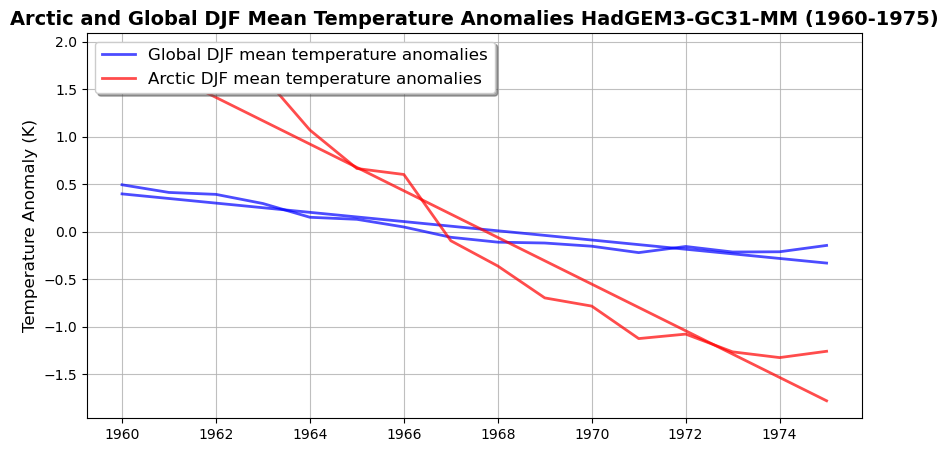

In [87]:
# Set up the figure
fig = plt.figure(figsize=(10, 5))

# Set up faint gridlines
plt.grid(alpha=0.8)

# Plot the global mean temperature
plt.plot(
    temps_df["effective_dec_year"].unique(),
    temps_df.groupby("effective_dec_year")["global_temp_anom"].mean(),
    label="Global DJF mean temperature anomalies",
    color="blue",
    alpha=0.7,
    linewidth=2,
)

# Calculate a linear trend for the global mean temperature
slope, intercept, r_value, p_value, std_err = linregress(
    temps_df["effective_dec_year"].unique(),
    temps_df.groupby("effective_dec_year")["global_temp_anom"].mean()
)

# Calculate the trend line
trend_line = slope * temps_df["effective_dec_year"].unique() + intercept

# print the shape of the trend line
print(trend_line.shape)

# Plot the trend line
plt.plot(
    temps_df["effective_dec_year"].unique(),
    trend_line,
    color="blue",
    alpha=0.7,
    linewidth=2,
)

# Plot the arctic mean temperature
plt.plot(
    temps_df["effective_dec_year"].unique(),
    temps_df.groupby("effective_dec_year")["arctic_temp_anom"].mean(),
    label="Arctic DJF mean temperature anomalies",
    color="red",
    alpha=0.7,
    linewidth=2,
)

# Calculate a linear trend for the arctic mean temperature
slope, intercept, r_value, p_value, std_err = linregress(
    temps_df["effective_dec_year"].unique(),
    temps_df.groupby("effective_dec_year")["arctic_temp_anom"].mean()
)

# Calculate the trend line
trend_line = slope * temps_df["effective_dec_year"].unique() + intercept

# Plot the trend line
plt.plot(
    temps_df["effective_dec_year"].unique(),
    trend_line,
    color="red",
    alpha=0.7,
    linewidth=2,
)

# Include a legend in the top left
plt.legend(
    loc="upper left",
    fontsize=12,
    frameon=True,
    shadow=True,
    fancybox=True,
)

# Set a ylabel
plt.ylabel("Temperature Anomaly (K)", fontsize=12)

# Set up the title
plt.title(
    "Arctic and Global DJF Mean Temperature Anomalies HadGEM3-GC31-MM (1960-1975)",
    fontsize=14,
    fontweight="bold",
)